In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import datetime
from scipy.interpolate import interp1d

def extract_frames(video_path, resize_dim=(100, 100)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_times = []
    fps = cap.get(cv2.CAP_PROP_FPS)  # Get the FPS of the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        resized_frame = cv2.resize(frame, resize_dim)  # Resize the frame
        gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame.flatten())
        frame_times.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0)  # Get the timestamp in seconds
    cap.release()
    return frames, frame_times, fps
 
def find_small_clip_in_video(small_clip_frames, large_video_frames, threshold=50):
    match_indices = []
    euclidean_scores = []
    for large_video_frame in large_video_frames:
        distances = [euclidean(small_clip_frame, large_video_frame) for small_clip_frame in small_clip_frames]
        min_index = np.argmin(distances)
        min_distance = distances[min_index]
        match_indices.append(min_index)
        euclidean_scores.append(min_distance)
    
    return match_indices, euclidean_scores

def check_sequence(match_indices):
    return all(match_indices[i] < match_indices[i+1] for i in range(len(match_indices)-1))

def find_start_time(match_indices, frame_times):
    if check_sequence(match_indices):
        start_frame_index = match_indices[0]
        return frame_times[start_frame_index]
    return None

def plot_euclidean_scores(euclidean_scores, frame_times):
    plt.figure(figsize=(10, 5))
    plt.plot(frame_times, euclidean_scores, label='Euclidean Distance')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Euclidean Distance')
    plt.title('Euclidean Distance of Matching Frames Over Time in Larger Video')
    plt.legend()
    plt.show()




## Euclidean Distance Of Video

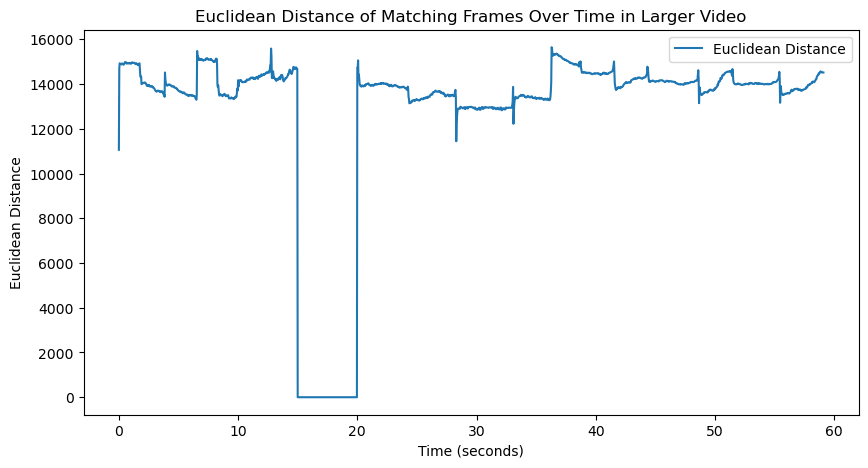

In [2]:
# Main script
startdate = datetime.datetime.now()

# Define a common resize dimension
resize_dim = (100, 100)

small_clip_path = 'TestAudio1/LargeVideoWhatsapp_Clipped.mp4' #'TestAudio1/LargeVideoWhatsapp_Clipped.mp4'
large_video_path = 'TestAudio1/LargeVideoWhatsapp.mp4'
small_clip_frames, _, small_clip_fps = extract_frames(small_clip_path, resize_dim)
large_video_frames, frame_times, large_video_fps = extract_frames(large_video_path, resize_dim)

match_indices, euclidean_scores = find_small_clip_in_video(small_clip_frames, large_video_frames)
start_time = find_start_time(match_indices, frame_times)

plot_euclidean_scores(euclidean_scores, frame_times)

In [3]:
from moviepy.editor import VideoFileClip
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Function to extract audio from mp4
def extract_audio_from_mp4(mp4_path):
    video = VideoFileClip(mp4_path)
    audio = video.audio
    audio_path = mp4_path.replace('.mp4', '.wav')
    audio.write_audiofile(audio_path)
    return audio_path

# Extract audio from the two mp4 files
audio_small_clip_path = extract_audio_from_mp4(small_clip_path)#'TestAudio1/LargeVideoWhatsapp.mp4')
audio_large_video_path = extract_audio_from_mp4(large_video_path)#'TestAudio1/LargeVideoWhatsapp_Clipped.mp4')

# Load the extracted audio files
y1, sr1 = librosa.load(audio_large_video_path)
y2, sr2 = librosa.load(audio_small_clip_path)


MoviePy - Writing audio in TestAudio1/LargeVideoWhatsapp_Clipped.wav


MoviePy - Done.


MoviePy - Writing audio in TestAudio1/LargeVideoWhatsapp.wav


MoviePy - Done.


## Euclidean Distance Of Audio

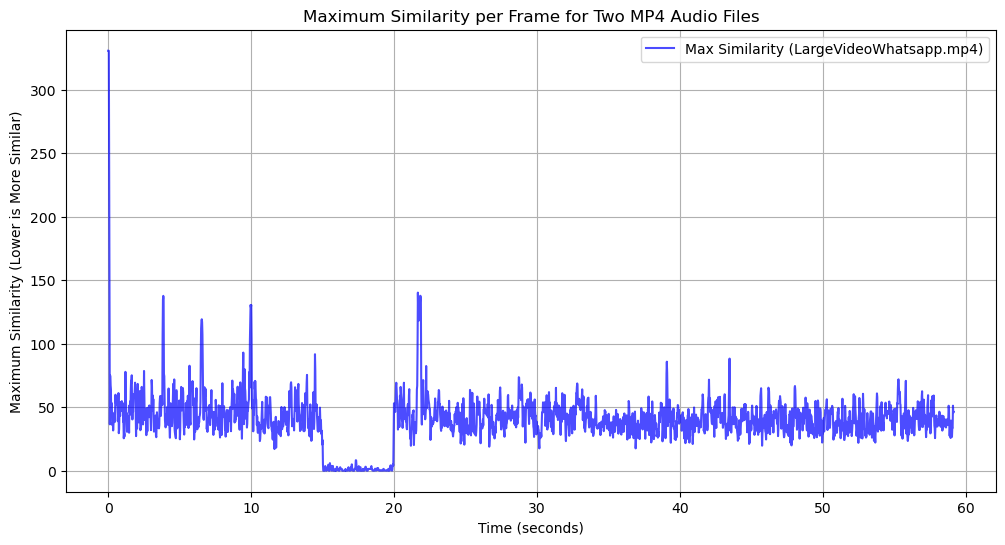

In [4]:
# Extract MFCCs with a specific hop length
hop_length = 512
mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=13, hop_length=hop_length)
mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=13, hop_length=hop_length)

# Calculate the Euclidean distance between the MFCC features
distance_matrix = cdist(mfcc1.T, mfcc2.T, metric='euclidean')

# Find the minimum distance (maximum similarity) for each frame
max_similarity_1 = np.min(distance_matrix, axis=1)
max_similarity_2 = np.min(distance_matrix, axis=0)

# Create the time axis in seconds for each audio
time_1 = np.arange(len(max_similarity_1)) * hop_length / sr1
time_2 = np.arange(len(max_similarity_2)) * hop_length / sr2

# Plot the similarity without interpolation
plt.figure(figsize=(12, 6))

# Plot for the first audio file with time on the x-axis
plt.plot(time_1, max_similarity_1, label='Max Similarity (LargeVideoWhatsapp.mp4)', color='blue', alpha=0.7)

# Plot for the second audio file with time on the x-axis
#plt.plot(time_2, max_similarity_2, label='Max Similarity (LargeVideoWhatsapp_Clipped.mp4)', color='orange', alpha=0.7)

plt.xlabel('Time (seconds)')
plt.ylabel('Maximum Similarity (Lower is More Similar)')
plt.title('Maximum Similarity per Frame for Two MP4 Audio Files')
plt.legend()
plt.grid(True)
plt.show()


### SImilarity of Audios (See linear line diagonally)

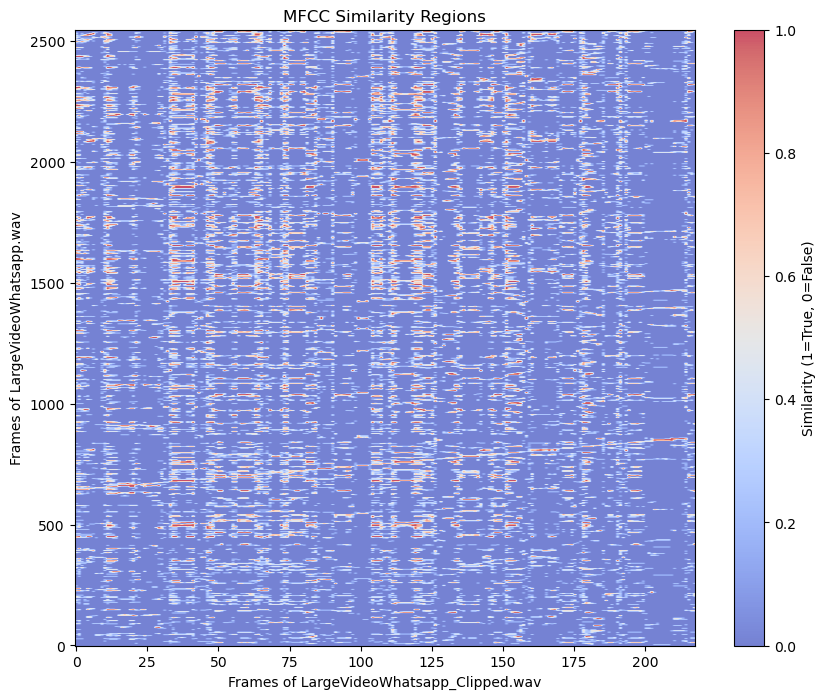

In [5]:
# Set a threshold for similarity (lower distances mean higher similarity)
threshold = np.percentile(distance_matrix, 10)  # Highlight the top 10% most similar regions

# Create a mask for regions that meet the similarity threshold
similarity_mask = distance_matrix < threshold

plt.figure(figsize=(10, 8))
plt.imshow(similarity_mask, origin='lower', aspect='auto', cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Similarity (1=True, 0=False)')
plt.title('MFCC Similarity Regions')
plt.xlabel('Frames of LargeVideoWhatsapp_Clipped.wav')
plt.ylabel('Frames of LargeVideoWhatsapp.wav')
plt.show()


In [6]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [7]:
def cap_outliers(data, percentile=99):
    threshold = np.percentile(data, percentile)
    capped_data = np.clip(data, None, threshold)
    return capped_data

In [8]:
def plot_combined_scores(frame_times, euclidean_scores, time_1, max_similarity_1):
    plt.figure(figsize=(10, 5))
    
    # Plot Euclidean scores over time
    plt.plot(frame_times, euclidean_scores, label='Euclidean Distance Video', color='blue')
    
    # Plot Max Similarity scores over time
    plt.plot(time_1, max_similarity_1, label='Euclidean Distance Audio', color='orange')
    
    # Set labels and title
    plt.xlabel('Time (seconds)')
    plt.ylabel('Score')
    plt.title('Euclidean Distance For Audio And Video Over Time')
    plt.legend()
    
    # Show the plot
    plt.show()

In [9]:
# Cap the top 1% outliers
capped_euclidean_scores = cap_outliers(euclidean_scores, percentile=99)
capped_max_similarity_1 = cap_outliers(max_similarity_1, percentile=99)

# Normalize the Euclidean scores and Max Similarity scores
normalized_euclidean_scores = normalize(capped_euclidean_scores)
normalized_max_similarity_1 = normalize(capped_max_similarity_1)

### Euclidean Distance Of Video And Audio Normalized

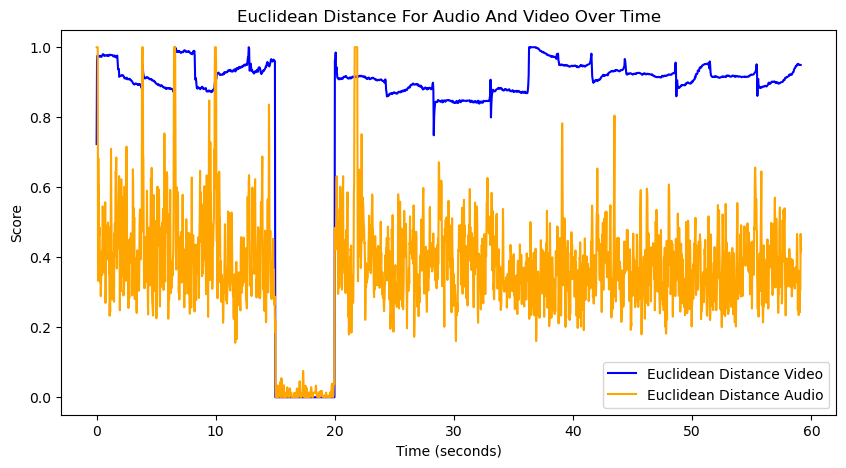

In [10]:
plot_combined_scores(frame_times, normalized_euclidean_scores, time_1, normalized_max_similarity_1)

In [11]:
def plot_combined_scores(frame_times, combined_scores):
    plt.figure(figsize=(10, 5))
    
    # Plot combined scores over time
    plt.plot(frame_times, combined_scores, label='Combined Score', color='purple')
    
    # Set labels and title
    plt.xlabel('Time (seconds)')
    plt.ylabel('Combined Score')
    plt.title('Combined Euclidean Distance and Max Similarity Over Time')
    plt.legend()
    
    # Show the plot
    plt.show()

## Euclidean Distance Of Normalized Video and Audio Combined 

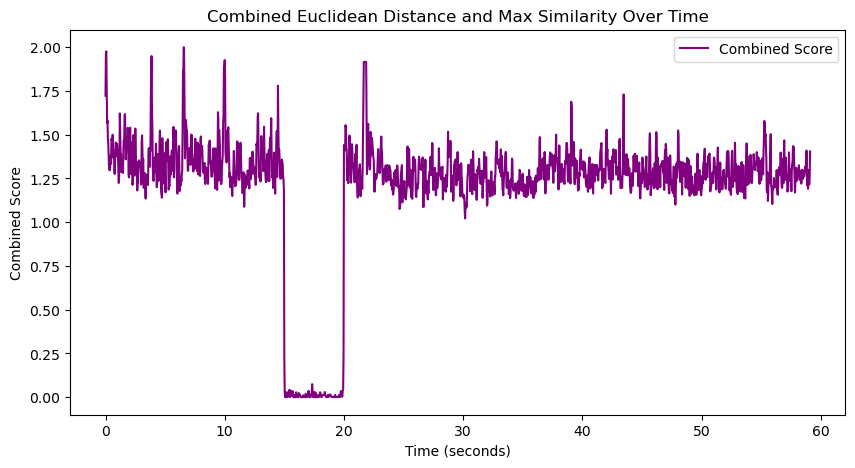

In [12]:
#Normalized Combined similarity 

from scipy.interpolate import interp1d

interp_func = interp1d(time_1, normalized_max_similarity_1, kind='linear', fill_value="extrapolate")
max_similarity_interp = interp_func(frame_times)

# Add Euclidean scores and interpolated Max Similarity scores
combined_scores = normalized_euclidean_scores + max_similarity_interp

# Plot the combined scores
plot_combined_scores(frame_times, combined_scores)

## Euclidean Distance Of Video and Audio Combined (Not Normalized)

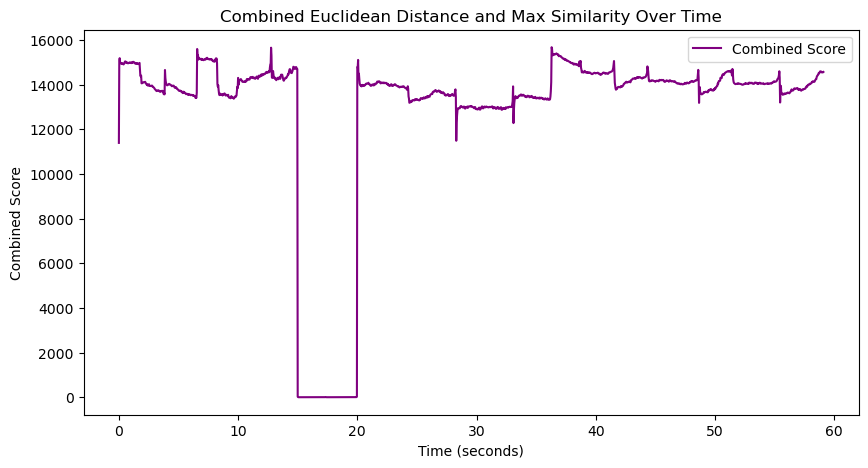

In [13]:
# Assuming time_1 and max_similarity_1 are already calculated elsewhere in your script:
# time_1 = [...]  # List of time values in seconds
# max_similarity_1 = [...]  # List of similarity scores

from scipy.interpolate import interp1d


# # For demonstration purposes, let's assume some example data for time_1 and max_similarity_1:
# time_1 = np.linspace(0, frame_times[-1], len(frame_times))  # Example time values
# max_similarity_1 = np.random.random(len(time_1))  # Example similarity scores

# Interpolate max_similarity_1 to match the frame_times
interp_func = interp1d(time_1, max_similarity_1, kind='linear', fill_value="extrapolate")
max_similarity_interp = interp_func(frame_times)

# Add Euclidean scores and interpolated Max Similarity scores
combined_scores = euclidean_scores + max_similarity_interp

# Plot the combined scores
plot_combined_scores(frame_times, combined_scores)